<a href="https://colab.research.google.com/github/wj198414/ASTRON1221/blob/main/DarkEnergy/Supernovae_cosmology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import astropy.io.ascii
import astropy.units as u
import astropy.constants as ac

In [14]:
from google.colab import files
uploaded = files.upload()

Saving Tonry_2003..vot to Tonry_2003. (1).vot


In [16]:
dat = astropy.io.ascii.read("Tonry_2003.vot")

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Text(0, 0.5, 'Velocity [km/s]')

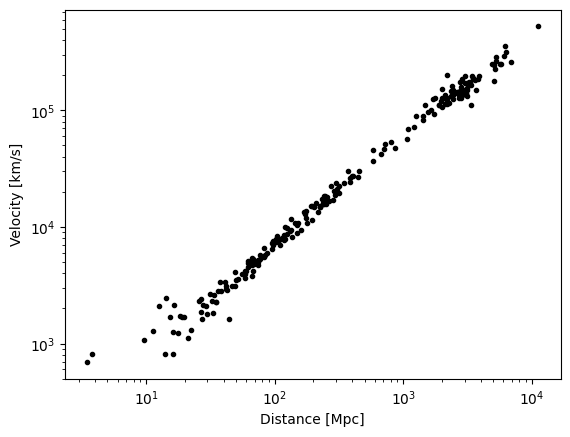

In [21]:
distance = 10**dat["col8"] / 72.0 * u.mpc
distance_error = (10**(dat["col8"]+dat["col9"]) - 10**dat["col8"]) / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.plot(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, marker=".", color="black", linestyle="none")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

Text(0, 0.5, 'Velocity [km/s]')

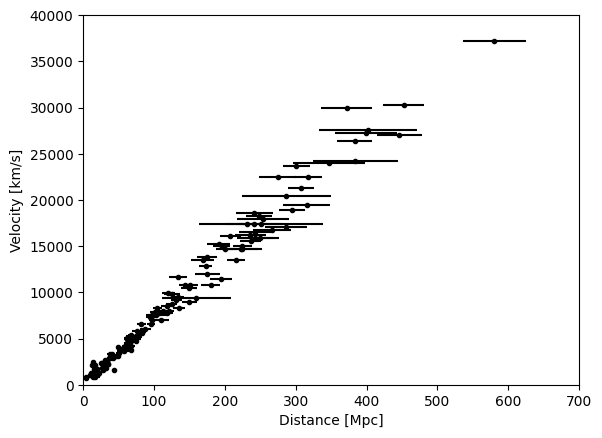

In [22]:
distance = 10**dat["col8"] / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.xlim(0, 700)
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

In [18]:
dat

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11
str8,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64
SN1972E,314.84,30.08,0.0023,N5253,16,2.839,2.399,0.033,204.9697,-31.6692
SN1980N,240.161,-56.689,0.0056,N1316,9,3.225,3.14,0.043,50.6753,-37.2074
SN1981B,292.97,64.743,0.0072,N4536,2,3.334,3.077,0.041,188.6233,2.1995
SN1981D,240.161,-56.689,0.0056,N1316,9,3.225,3.044,0.055,50.6753,-37.2074
SN1986G,309.543,19.401,0.0027,N5128,26,2.908,2.44,0.035,201.4028,-43.0316
SN1988U,8.737,-81.227,0.31,Anon,24,4.968,5.096,0.072,3.5756,-30.4164
SN1989B,241.991,64.403,0.0036,N3627,37,3.033,2.844,0.03,170.0578,12.9718
SN1990N,294.369,75.987,0.0044,N4639,21,3.12,3.204,0.035,190.7367,13.2566
SN1990O,37.654,28.36,0.0307,M+034403,10,3.964,3.977,0.025,258.8999,16.3241


In [20]:
distance_error

<Quantity [0.01498537, 0.01533443, 0.01526397, 0.01576404, 0.01505454,
           0.01639334, 0.01488221, 0.01505454, 0.01471186, 0.01529916,
           0.01519384, 0.01474577, 0.01488221, 0.01529916, 0.01481384,
           0.01495091, 0.01471186, 0.01505454, 0.01464426, 0.01488221,
           0.01498537, 0.01508924, 0.01477976, 0.01474577, 0.01491652,
           0.01474577, 0.01477976, 0.01488221, 0.01457698, 0.01488221,
           0.01474577, 0.01728493, 0.01471186, 0.01461058, 0.01457698,
           0.01474577, 0.01477976, 0.01474577, 0.01474577, 0.01474577,
           0.01474577, 0.01533443, 0.01467802, 0.01474577, 0.01495091,
           0.01488221, 0.01508924, 0.01474577, 0.01650698, 0.01748508,
           0.01594658, 0.01474577, 0.01474577, 0.01467802, 0.01471186,
           0.01488221, 0.01481384, 0.01609413, 0.0158368 , 0.01673661,
           0.01467802, 0.01501992, 0.01515889, 0.01536977, 0.01481384,
           0.01693041, 0.01498537, 0.01474577, 0.0198915 , 0.01830912,
      